# Step 1: Import Required Libraries


In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# LIBRARY USAGE BREAKDOWN:


PyTorch Components:
- torch: Core tensor operations and GPU acceleration
- nn: Neural network layers, activation functions, loss functions
- optim: Optimizers for model parameter updates during training
- DataLoader: Batch processing and data loading utilities
- Dataset: Base class for creating custom datasets

Computer Vision:
- transforms: Image preprocessing, augmentation, and normalization
- models: Pre-trained neural network architectures (AlexNet, ResNet, etc.)
- PIL.Image: Loading and basic image processing operations

Data Science & Visualization:
- numpy: Mathematical operations and array manipulations
- matplotlib: Creating plots, charts, and image displays
- seaborn: Statistical data visualization and heatmaps
- pandas: Data analysis and manipulation (if working with CSV files)

Machine Learning Utilities:
- train_test_split: Dataset splitting for training and evaluation
- classification_report: Detailed classification performance metrics
- confusion_matrix: Visualization of model prediction accuracy

Utilities:
- os: File system operations and path handling
- tqdm: Progress bars for training loops and data loading

In [3]:
# Mount Google Drive to access dataset (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 2: Define Dataset Path and Configuration


In [4]:
# Define the path to your dataset in Google Drive
# Replace this with your actual dataset path

# WITH THIS:
dataset_path = "/content/drive/MyDrive/your_dataset_folder_here"
classes = ['class_0', 'class_1']  # Replace with your actual class names with your actual dataset folder name
num_classes = len(classes)  # Number of classification categories

# Verify dataset path exists and check class distribution
if not os.path.exists(dataset_path):
    print(f" Dataset path {dataset_path} does not exist!")
    print("Please check the path and update the dataset_path variable")
else:
    print("Dataset path found successfully!")

    # Check each class folder and count images
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)  # Create full path to class folder

        if os.path.exists(class_path):
            # Count all image files in the class directory
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            num_images = len(image_files)
            print(f" Class '{class_name}': {num_images} images")
        else:
            print(f" Warning: Class directory '{class_name}' not found!")

Dataset path found successfully!
 Class '0': 96 images
 Class '1': 94 images


# Step 3: Load dataset and split it for training validation and testing

In [5]:
#Intially we are creating a function for loas and split the dataset in this cell function is created
def load_and_split_dataset(dataset_path, classes, test_size=0.2, val_size=0.15, random_state=42):
    """
    Load all image paths and labels, then split into train/val/test sets

    Args:
        dataset_path: Path to the main dataset directory
        classes: List of class names ['Normal', 'Abnormal']
        test_size: Proportion of data for testing (default: 20%)
        val_size: Proportion of data for validation (default: 15%)
        random_state: Seed for reproducible splits
    """
    image_paths = []
    labels = []

    print("Loading dataset and creating splits...")

    # Iterate through each class folder
    for class_idx, class_name in enumerate(classes):
        class_folder_path = os.path.join(dataset_path, class_name)

        # Check if class folder exists
        if not os.path.exists(class_folder_path):
            print(f"Warning: Folder '{class_name}' not found in {dataset_path}")
            continue

        # Get all image files in the class folder
        image_files = [f for f in os.listdir(class_folder_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        print(f"Found {len(image_files)} images in class '{class_name}'")

        # Add each image path and its corresponding label
        for img_file in image_files:
            img_path = os.path.join(class_folder_path, img_file)
            image_paths.append(img_path)
            labels.append(class_idx)  # 0 for Normal, 1 for Abnormal

    print(f"\nTotal images loaded: {len(image_paths)}")

    # Check if we have enough data to split
    if len(image_paths) == 0:
        print("Error: No images found! Please check your dataset path and structure.")
        return None

    # First split: Separate test set (20%)
    # stratify=labels ensures balanced class distribution in all splits
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        image_paths, labels,
        test_size=test_size,          # 20% for testing
        random_state=random_state,    # Seed for reproducibility
        stratify=labels               # Maintain class balance
    )

    # Second split: Split remaining data into train and validation
    # val_size is relative to the train_val set size (15% of original = 18.75% of train_val)
    relative_val_size = val_size / (1 - test_size)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels,
        test_size=relative_val_size,  # 15% of original data for validation
        random_state=random_state,
        stratify=train_val_labels
    )

    return train_paths, train_labels, val_paths, val_labels, test_paths, test_labels

In [6]:
#In this process we are calling the function and load the dataset and print the details of the dataset...
# Load and split the dataset call the above function
train_paths, train_labels, val_paths, val_labels, test_paths, test_labels = load_and_split_dataset(
    dataset_path, classes, test_size=0.2, val_size=0.15
)

# Print detailed split information
print(f"\n{'='*50}")
print("DATASET SPLIT SUMMARY")
print(f"{'='*50}")

total_images = len(train_paths) + len(val_paths) + len(test_paths)
print(f"Total images: {total_images}")
print(f"Training set: {len(train_paths)} images ({len(train_paths)/total_images*100:.1f}%)")
print(f"Validation set: {len(val_paths)} images ({len(val_paths)/total_images*100:.1f}%)")
print(f"Test set: {len(test_paths)} images ({len(test_paths)/total_images*100:.1f}%)")

# Print class distribution for each split
def print_class_distribution(paths, labels, split_name, classes):
    """Print class distribution for a given split"""
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{split_name} Set Class Distribution:")
    for cls_idx, count in zip(unique, counts):
        percentage = count/len(labels)*100
        print(f"  {classes[cls_idx]}: {count} images ({percentage:.1f}%)")

print_class_distribution(train_paths, train_labels, "TRAINING", classes)
print_class_distribution(val_paths, val_labels, "VALIDATION", classes)
print_class_distribution(test_paths, test_labels, "TEST", classes)

Loading dataset and creating splits...
Found 96 images in class '0'
Found 94 images in class '1'

Total images loaded: 190

DATASET SPLIT SUMMARY
Total images: 190
Training set: 123 images (64.7%)
Validation set: 29 images (15.3%)
Test set: 38 images (20.0%)

TRAINING Set Class Distribution:
  0: 62 images (50.4%)
  1: 61 images (49.6%)

VALIDATION Set Class Distribution:
  0: 15 images (51.7%)
  1: 14 images (48.3%)

TEST Set Class Distribution:
  0: 19 images (50.0%)
  1: 19 images (50.0%)


#Details of Class below
This class serves as a bridge between your raw image data and PyTorch's DataLoader, enabling efficient batch processing during model training and evaluation.

Key Components and Functionality:
1. Initialization (__init__ method):

Image Paths Storage: Accepts and stores a list of file paths pointing to individual images

Label Storage: Maintains a corresponding list of numerical labels where 0 represents "Normal"  and 1 represents "Abnormal" cases

Transform Pipeline: Stores an optional transformation object that will be applied to each image during loading, which typically includes resizing, normalization, and data augmentation operations

2. Length Method (__len__):

Returns the total number of samples in the dataset by simply checking the length of the image paths list

This enables PyTorch to determine the dataset size for epoch calculations and progress tracking

3. Item Retrieval (__getitem__ method):

Index-based Access: Retrieves a specific sample using its index position in the dataset

Image Loading: Opens the image file from the stored path using PIL (Python Imaging Library)

RGB Conversion: Ensures all images are converted to RGB format, which is crucial because:


This conversion creates three identical channels from single-channel grayscale images it required

Maintains compatibility with pre-trained models trained on RGB datasets like ImageNet

Transformation Application: Applies the specified transformation pipeline to the loaded image, which may include:

Resizing to a consistent dimension (e.g., 224x224 for AlexNet)

Data augmentation techniques (flipping, rotation, color jitter)

Normalization to standard value ranges

Tensor conversion for PyTorch compatibility

Return Format: Returns a tuple containing the processed image tensor and its corresponding label, ready for model consumption

Technical Workflow:
When this dataset is used with a PyTorch DataLoader, the __getitem__ method is called repeatedly to:

Fetch individual samples during training

Apply on-the-fly transformations for data augmentation

Provide properly formatted tensors to the neural network

Maintain the correct association between images and their diagnostic labels

Importance in Medical Imaging Pipeline:
Data Consistency: Ensures all images are processed uniformly regardless of original format

Memory Efficiency: Loads images on-demand rather than storing all in memory

Reproducibility: Maintains consistent preprocessing across training and inference

Flexibility: Allows easy swapping of transformation strategies for different experiments


In [7]:
# Create a custom dataset class for images
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths: List of paths to image files
            labels: List of corresponding labels (0=Normal, 1=Abnormal)
            transform: Image transformations to apply
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Return the total number of samples
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Load and return one sample from the dataset
        """
        # Get image path and label for the given index
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open image and convert to RGB (even if grayscale)
        image = Image.open(image_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label


#Mention Transforms for training and testing images

In [8]:
# If you want to be explicit about the 0-1 range
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),

    # Explicit normalization to [0,1] (redundant but clear)
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])

In [9]:
train_dataset = CustomImageDataset(train_paths, train_labels, transform=train_transform)
val_dataset = CustomImageDataset(val_paths, val_labels, transform=test_transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform=test_transform)


print(f"\nDataset objects created successfully!")
print(f"Training dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")



Dataset objects created successfully!
Training dataset: 123 samples
Validation dataset: 29 samples
Test dataset: 38 samples


#Create Dataloaders thet will help us to push the dataset inside the DL network

In [10]:
# Create data loaders for batch processing
batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,    # Shuffle training data for each epoch
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,   # No need to shuffle validation data
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,   # No shuffle for test data
    num_workers=0
)

print(f"\nData Loaders Created:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Data Loaders Created:
Training batches: 16
Validation batches: 4
Test batches: 5


#Check for the overlapping or data leakage among train, val test split

In [11]:
# Function to verify our splits
def verify_splits(train_paths, val_paths, test_paths):
    """Verify that there's no overlap between splits"""

    # Convert to sets for comparison
    train_set = set(train_paths)
    val_set = set(val_paths)
    test_set = set(test_paths)

    # Check for overlaps
    train_val_overlap = train_set.intersection(val_set)
    train_test_overlap = train_set.intersection(test_set)
    val_test_overlap = val_set.intersection(test_set)

    print("SPLIT VERIFICATION")


    if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
        print(" SUCCESS: No overlap between train, val, and test sets!")
    else:
        print("ERROR: Overlap detected between splits!")
        if train_val_overlap:
            print(f"Train-Val overlap: {len(train_val_overlap)} images")
        if train_test_overlap:
            print(f"Train-Test overlap: {len(train_test_overlap)} images")
        if val_test_overlap:
            print(f"Val-Test overlap: {len(val_test_overlap)} images")

    # Check total unique images
    all_images = train_set.union(val_set).union(test_set)
    print(f"Total unique images: {len(all_images)}")

# Run verification
verify_splits(train_paths, val_paths, test_paths)

SPLIT VERIFICATION
 SUCCESS: No overlap between train, val, and test sets!
Total unique images: 190


In [12]:
# Test if the dataset works correctly
print("\nTesting dataset with a sample...")
try:
    # Get one sample from training set
    sample_image, sample_label = train_dataset[0]
    print(f"Dataset works! Sample image shape: {sample_image.shape}")
    print(f"Sample label: {sample_label} ({classes[sample_label]})")

    # Test data loader
    sample_batch = next(iter(train_loader))
    images, labels = sample_batch
    print(f" DataLoader works! Batch size: {images.shape[0]}")
    print(f" Batch image shape: {images.shape}")
    print(f" Batch labels: {labels}")

except Exception as e:
    print(f" Error: {e}")


Testing dataset with a sample...
Dataset works! Sample image shape: torch.Size([3, 224, 224])
Sample label: 0 (0)
 DataLoader works! Batch size: 8
 Batch image shape: torch.Size([8, 3, 224, 224])
 Batch labels: tensor([1, 0, 0, 0, 1, 1, 1, 0])


#Visualize the random images of training, validation and test dataset

Displaying sample images from all splits...


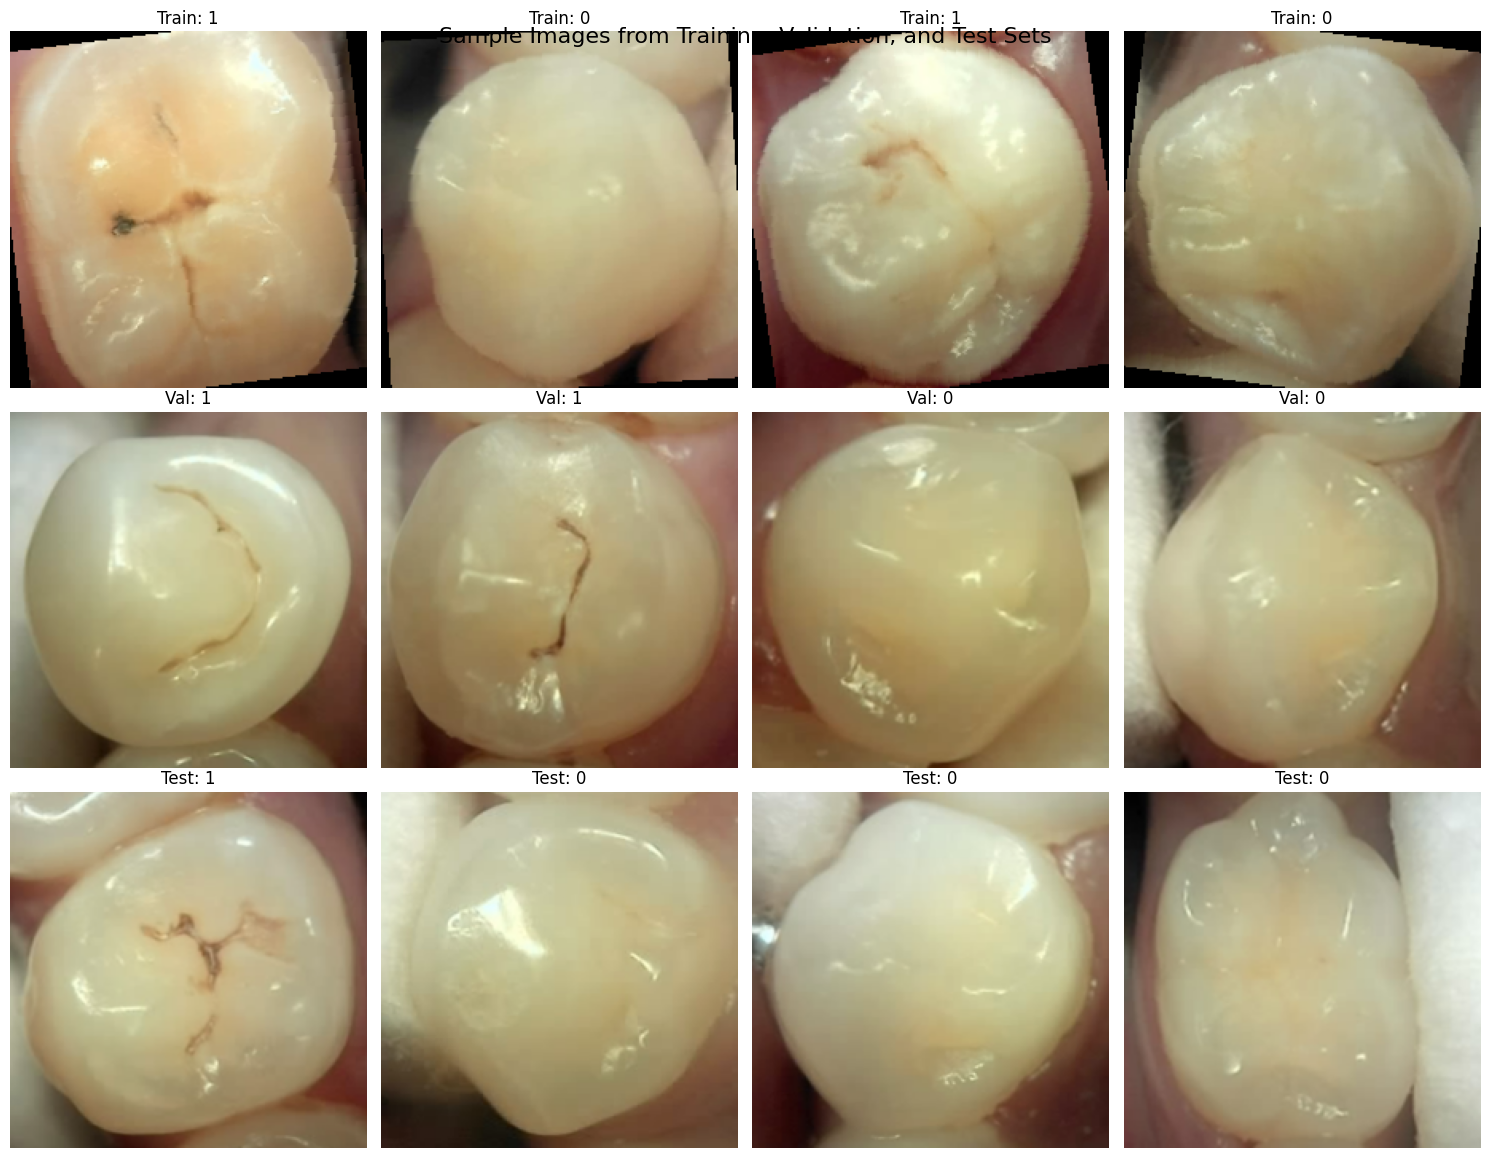

In [13]:
def display_dataset_samples(train_loader, val_loader, test_loader, classes, num_samples=8):
    """
    Display sample images from training, validation, and test sets
    """
    # Create a figure with 3 rows for each split
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))

    # Get samples from training set
    train_images, train_labels = next(iter(train_loader))

    # Display training samples
    for i in range(4):
        if i < len(train_images):
            # Convert tensor to numpy for plotting
            # Remove the normalization and transpose dimensions
            img = train_images[i].numpy().transpose(1, 2, 0)

            # Clip values to valid range [0, 1]
            img = np.clip(img, 0, 1)

            axes[0, i].imshow(img)
            axes[0, i].set_title(f'Train: {classes[train_labels[i]]}')
            axes[0, i].axis('off')

    # Get samples from validation set
    val_images, val_labels = next(iter(val_loader))

    # Display validation samples
    for i in range(4):
        if i < len(val_images):
            img = val_images[i].numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)

            axes[1, i].imshow(img)
            axes[1, i].set_title(f'Val: {classes[val_labels[i]]}')
            axes[1, i].axis('off')

    # Get samples from test set
    test_images, test_labels = next(iter(test_loader))

    # Display test samples
    for i in range(4):
        if i < len(test_images):
            img = test_images[i].numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)

            axes[2, i].imshow(img)
            axes[2, i].set_title(f'Test: {classes[test_labels[i]]}')
            axes[2, i].axis('off')

    plt.suptitle('Sample Images from Training, Validation, and Test Sets', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

# Display the samples
print("Displaying sample images from all splits...")
display_dataset_samples(train_loader, val_loader, test_loader, classes)

# Define the network architecture

In [15]:
import torch.nn as nn
import torch.optim as optim

class OriginalAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(OriginalAlexNet, self).__init__()

        # Feature extraction layers (EXACTLY as in original paper)
        # AlexNet expects 224x224 input images
        self.features = nn.Sequential(
            # Conv1: 96 filters, 11x11 kernel, stride 4
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # Original LRN
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv2: 256 filters, 5x5 kernel, padding 2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # Original LRN
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3: 384 filters, 3x3 kernel, padding 1
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv4: 384 filters, 3x3 kernel, padding 1
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv5: 256 filters, 3x3 kernel, padding 1
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Adaptive average pooling to handle different sizes
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # Classifier layers (EXACTLY as in original paper)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),  # Output for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

print("✅ Original AlexNet architecture defined!")

✅ Original AlexNet architecture defined!


In [16]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the original AlexNet model
# This model expects 224x224 input images
model = OriginalAlexNet(num_classes=num_classes)

# Move model to GPU if available
model = model.to(device)

# Define loss function for binary classification
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD as in original paper, but with smaller learning rate for our dataset)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("✅ Model initialized successfully!")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Using device: cuda
✅ Model initialized successfully!
Number of trainable parameters: 58,289,538


In [17]:
# # If you dont want to create the network then you can import the model fromtorchvision library
# # to uncomment the cell use : Select all->then click (Ctrl+/)

# from torchvision import models
# import torch.nn as nn

# # Check for GPU availability
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Call the AlexNet model
# # This model expects 224x224 input images
# model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# # Modify the classifier for binary classification
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, num_classes)
# model = model.to(device)

# # Move model to GPU if available
# model = model.to(device)

# # Define loss function for binary classification
# criterion = nn.CrossEntropyLoss()

# # Define optimizer (SGD as in original paper, but with smaller learning rate for our dataset)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# # Learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# print("✅ Model initialized successfully!")
# print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

In [18]:
# Fix the model saving path - use a simple path without special characters
import os

# Create a simple directory for saving models
save_dir = "/content/drive/MyDrive/models/path_to_save_model" # Replce path where u want to save your model
os.makedirs(save_dir, exist_ok=True)

model_save_path = os.path.join(save_dir, "best_alexnet_o2.pth")
print(f"Model will be saved to: {model_save_path}")

Model will be saved to: /content/drive/MyDrive/BML815_Alexnet_training /Dental/models/best_alexnet_o2.pth


#Create a function to train the and validate the network

# Function Overview
* Trains an AlexNet model for image classification with comprehensive monitoring

* Includes training loop, validation, and early stopping mechanisms

**1. Initialization & Setup**

    Tracks training/validation losses and accuracies in lists

    Sets up early stopping parameters (patience=10 epochs)

    Initializes best validation accuracy tracking

    Creates formatted progress display header

**2. Training Loop (per epoch)**

    Mode Setting: Switches model to train() mode for training phase

    Progress Tracking: Uses tqdm for real-time progress bars

    Device Management: Moves data to appropriate device (CPU/GPU)

    Gradient Handling: Zeros gradients before each backward pass

**3. Training Phase Operations**

    Forward Pass: Computes model predictions

    Loss Calculation: Applies criterion to compare predictions vs actual labels

    Backward Propagation: Computes gradients via loss.backward()

    Parameter Update: Applies optimizer step to update weights

    Accuracy Calculation: Tracks correct predictions and total samples

**4. Validation Phase**

    Mode Setting: Switches model to eval() mode

    Gradient Disabling: Uses torch.no_grad() to save memory

    Metrics Calculation: Computes validation loss and accuracy

    No Backpropagation: Validation doesn't update model weights

**5. Learning Rate Management**

    Applies learning rate scheduler after each epoch

    Automatically adjusts LR based on training progress

**6. Model Saving & Early Stopping**

    Best Model Check: Saves model only if validation accuracy improves

    Checkpoint Contents: Saves model weights, optimizer state, and metrics

    Patience Counter: Tracks consecutive epochs without improvement

    Early Stopping: Stops training if no improvement for 10 epochs

**7. Progress Monitoring**

    Real-time Updates: Live progress bars during training

    Epoch Summary: Formatted table output after each epoch

    Status Indicators: Shows "SAVED" when model improves or "WAIT X/10" when stagnant

**8. Return Values**

    Returns four lists containing:

    Training losses per epoch

    Validation losses per epoch

    Training accuracies per epoch

    Validation accuracies per epoch

In [19]:
#In this function we are creating training loop
def train_alexnet(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50):
    """
    Train the original AlexNet model
    """
    # Lists to track metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Early stopping parameters
    best_val_acc = 0.0
    patience = 10
    patience_counter = 0

    print("Starting AlexNet training...")
    print(f"{'Epoch':^6} | {'Train Loss':^10} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^10} | {'Status':^10}")
    print("-" * 70)

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

        for batch_idx, (images, labels) in enumerate(train_pbar):
            # Move data to appropriate device
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * correct / total:.2f}%'
            })

        # Calculate training metrics
        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate validation metrics
        val_accuracy = 100 * correct / total
        val_loss = val_loss / len(val_loader)

        # Update learning rate
        scheduler.step()

        # Store metrics for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print epoch results
        print(f"{epoch+1:^6} | {train_loss:^10.4f} | {train_accuracy:^10.2f} | {val_loss:^10.4f} | {val_accuracy:^10.2f} | ", end='')

        # Save best model and check for early stopping
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            # Save the best model with simple path
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy
            }, model_save_path)
            print('SAVED     ')
        else:
            patience_counter += 1
            print(f'WAIT {patience_counter}/{patience}')

        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [22]:
# Start the training process
print("Starting AlexNet Training on your Dataset...")
train_losses, val_losses, train_accuracies, val_accuracies = train_alexnet(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=50
)

Starting AlexNet Training on your Dataset...
Starting AlexNet training...
Epoch  | Train Loss | Train Acc  |  Val Loss  |  Val Acc   |   Status  
----------------------------------------------------------------------


Epoch 1/50 [Train]: 100%|██████████| 16/16 [00:01<00:00, 10.34it/s, Loss=0.6922, Acc=50.41%]


  1    |   0.6930   |   50.41    |   0.6929   |   51.72    | SAVED     


Epoch 2/50 [Train]: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s, Loss=0.6943, Acc=50.41%]


  2    |   0.6933   |   50.41    |   0.6929   |   51.72    | WAIT 1/10


Epoch 3/50 [Train]: 100%|██████████| 16/16 [00:01<00:00, 11.17it/s, Loss=0.6940, Acc=50.41%]


  3    |   0.6932   |   50.41    |   0.6929   |   51.72    | WAIT 2/10


Epoch 4/50 [Train]: 100%|██████████| 16/16 [00:01<00:00, 11.59it/s, Loss=0.6943, Acc=51.22%]


  4    |   0.6931   |   51.22    |   0.6929   |   51.72    | WAIT 3/10


Epoch 5/50 [Train]: 100%|██████████| 16/16 [00:01<00:00,  9.67it/s, Loss=0.6915, Acc=50.41%]


  5    |   0.6929   |   50.41    |   0.6929   |   51.72    | WAIT 4/10


Epoch 6/50 [Train]: 100%|██████████| 16/16 [00:01<00:00,  8.81it/s, Loss=0.6890, Acc=50.41%]


  6    |   0.6929   |   50.41    |   0.6929   |   51.72    | WAIT 5/10


Epoch 7/50 [Train]: 100%|██████████| 16/16 [00:11<00:00,  1.44it/s, Loss=0.6901, Acc=50.41%]


  7    |   0.6928   |   50.41    |   0.6929   |   51.72    | WAIT 6/10


Epoch 8/50 [Train]: 100%|██████████| 16/16 [00:01<00:00,  8.11it/s, Loss=0.6930, Acc=50.41%]


  8    |   0.6931   |   50.41    |   0.6929   |   51.72    | WAIT 7/10


Epoch 9/50 [Train]: 100%|██████████| 16/16 [00:01<00:00, 10.00it/s, Loss=0.6924, Acc=50.41%]


  9    |   0.6931   |   50.41    |   0.6929   |   51.72    | WAIT 8/10


Epoch 10/50 [Train]: 100%|██████████| 16/16 [00:01<00:00,  9.70it/s, Loss=0.6911, Acc=50.41%]


  10   |   0.6928   |   50.41    |   0.6929   |   51.72    | WAIT 9/10


Epoch 11/50 [Train]: 100%|██████████| 16/16 [00:01<00:00,  9.62it/s, Loss=0.6922, Acc=49.59%]


  11   |   0.6931   |   49.59    |   0.6929   |   51.72    | WAIT 10/10

Early stopping triggered after 11 epochs


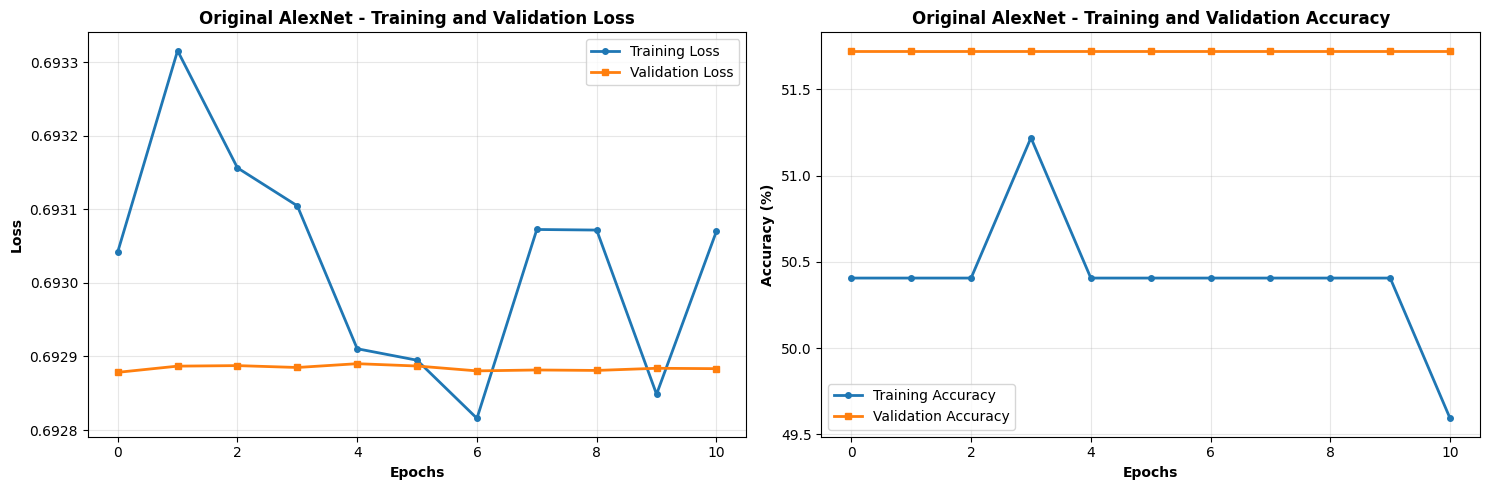

📈 Training plots saved and displayed!


In [24]:
# Create visualization of training history
plt.figure(figsize=(15, 5))

# Plot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2, marker='o', markersize=4)
plt.plot(val_losses, label='Validation Loss', linewidth=2, marker='s', markersize=4)
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Original AlexNet - Training and Validation Loss', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', linewidth=2, marker='o', markersize=4)
plt.plot(val_accuracies, label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Original AlexNet - Training and Validation Accuracy', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('original_alexnet_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("📈 Training plots saved and displayed!")

# Test the above trained Network using test dataset

In [25]:
# The below function is used to test the networok

def test_original_alexnet(model, test_loader, classes, model_path, device):
    """
    Comprehensive testing of the trained Original AlexNet model

    Args:
        model: The AlexNet model instance
        test_loader: DataLoader for test data
        classes: List of class names
        model_path: Path to saved model checkpoint
        device: Computation device
    """
    print(" TESTING ORIGINAL ALEXNET ON TEST SET")

    # Load the best saved model
    if not os.path.exists(model_path):
        print(f" Model file not found: {model_path}")
        return

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    print("Best model loaded successfully!")
    print(f"Saved at epoch: {checkpoint['epoch'] + 1}")
    print(f" Best validation accuracy: {checkpoint['val_accuracy']:.2f}%")

    # Test the model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    print("\n Running inference on test set...")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Calculate final metrics
    test_accuracy = 100 * correct / total
    test_loss = test_loss / len(test_loader)

    print(f"\n TEST SET RESULTS:")
    print(f"   Test Loss: {test_loss:.4f}")
    print(f"   Test Accuracy: {test_accuracy:.2f}%")
    print(f"   Correct: {correct}/{total}")

    return all_predictions, all_labels, all_probabilities, test_accuracy, test_loss


#Calling above function
# Run the test
all_predictions, all_labels, all_probabilities, test_accuracy, test_loss = test_original_alexnet(
    model, test_loader, classes, model_save_path, device
)

 TESTING ORIGINAL ALEXNET ON TEST SET
Best model loaded successfully!
Saved at epoch: 1
 Best validation accuracy: 51.72%

 Running inference on test set...

 TEST SET RESULTS:
   Test Loss: 0.6932
   Test Accuracy: 50.00%
   Correct: 19/38


#Phase-2 Now we did some modifications in Alexnet model as well as in the training parametrs so that it will perform better



In [26]:
import torch.nn as nn
import torch.optim as optim

class ImprovedAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ImprovedAlexNet, self).__init__()

        # Feature extraction layers - MODIFIED for better medical image processing
        self.features = nn.Sequential(
            # Conv1: Smaller kernel, less filters for medical images
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # Changed from 11x11 to 7x7
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),  # ADDED: BatchNorm for stability (better than LRN)
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv2: Reduced filters for smaller dataset
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192),  # ADDED: BatchNorm
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3-5: Keep similar but with BatchNorm
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),  # ADDED

            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Reduced from 384 to 256
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),  # ADDED

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),  # ADDED
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Adaptive average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # Classifier layers - MODIFIED for better regularization
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.6),  # INCREASED dropout for medical images
            nn.Linear(256 * 6 * 6, 2048),  # REDUCED neurons (4096 -> 2048)
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(2048),  # ADDED: BatchNorm in classifier

            nn.Dropout(p=0.6),  # INCREASED dropout
            nn.Linear(2048, 1024),  # REDUCED neurons (4096 -> 1024)
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),  # ADDED

            nn.Linear(1024, num_classes),  # Final output
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

print("✅ Improved AlexNet architecture defined!")

✅ Improved AlexNet architecture defined!


In [27]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the IMPROVED AlexNet model
model = ImprovedAlexNet(num_classes=num_classes)

# Move model to GPU if available
model = model.to(device)

# BETTER optimizer settings for medical images
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)  # AdamW is better than SGD for medical images

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # Better than StepLR

# Loss function
criterion = nn.CrossEntropyLoss()

print("✅ Improved model and training setup ready!")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Using device: cuda
✅ Improved model and training setup ready!
Number of parameters: 23,440,962


In [28]:
# IMPROVED transforms for medical images
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Slightly larger then crop
    transforms.RandomCrop((224, 224)),  # Random cropping for augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),  # Small rotation for medical images
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Small jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No augmentation for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Improved data transforms")

✅ Improved data transforms ready!


In [30]:
# Fix the model saving path - use a simple path without special characters
import os

# Create a simple directory for saving models
save_dir = "/content/drive/MyDrive/BML815_Alexnet_training /models/path_to_save_model"
os.makedirs(save_dir, exist_ok=True)

model_save_path = os.path.join(save_dir, "best_alexnet_modified_2.pth")
print(f"Model will be saved to: {model_save_path}")

Model will be saved to: /content/drive/MyDrive/BML815_Alexnet_training /Dental/models/best_alexnet_modified_2.pth


In [31]:
# This function is also used to train the network in this everything is same aa the previous code
# just some modification to calculate the time and improvement status

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import time

def train_improved_alexnet(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, model_save_path='best_model.pth'):
    """
    Train the improved AlexNet with comprehensive monitoring and visualization

    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        epochs: Number of training epochs
        model_save_path: Path to save the best model

    Returns:
        training_history: Dictionary containing all training metrics
    """

    # Initialize tracking variables
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    learning_rates = []

    best_val_acc = 0.0
    patience = 10
    patience_counter = 0

    # Get device
    device = next(model.parameters()).device

    print("🚀 Starting Improved AlexNet training...")
    print(f"{'Epoch':^6} | {'Train Loss':^10} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^10} | {'Best Val':^10} | {'LR':^10} | {'Status':^10}")
    print("-" * 105)

    # Training loop over epochs
    for epoch in range(epochs):
        # ==================== TRAINING PHASE ====================
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Create progress bar for training batches
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)

        for batch_idx, batch in enumerate(train_pbar):
            # Handle different batch formats
            if len(batch) == 3:
                images, labels, _ = batch  # With image paths
            else:
                images, labels = batch     # Without image paths

            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            # Update progress bar with current metrics
            current_acc = 100 * correct / total
            avg_loss = running_loss / (batch_idx + 1)
            train_pbar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Acc': f'{current_acc:.2f}%',
                'Batch': f'{batch_idx+1}/{len(train_loader)}'
            })

        # Calculate epoch training metrics
        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # ==================== VALIDATION PHASE ====================
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        # Create progress bar for validation batches
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False)

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_pbar):
                # Handle different batch formats
                if len(batch) == 3:
                    images, labels, _ = batch  # With image paths
                else:
                    images, labels = batch     # Without image paths

                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update progress bar
                current_acc = 100 * correct / total
                avg_loss = val_loss / (batch_idx + 1)
                val_pbar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Acc': f'{current_acc:.2f}%',
                    'Batch': f'{batch_idx+1}/{len(val_loader)}'
                })

        # Calculate epoch validation metrics
        val_accuracy = 100 * correct / total
        val_loss = val_loss / len(val_loader)

        # ==================== LEARNING RATE SCHEDULING ====================
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler is not None:
            scheduler.step(val_loss)  # Step based on validation loss
        learning_rates.append(current_lr)

        # ==================== STORE METRICS ====================
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # ==================== MODEL CHECKPOINTING ====================
        is_best = val_accuracy > best_val_acc
        old_best = best_val_acc

        if is_best:
            best_val_acc = val_accuracy
            patience_counter = 0

            # Save best model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'val_accuracy': val_accuracy,
                'val_loss': val_loss,
                'train_accuracy': train_accuracy,
                'train_loss': train_loss,
                'metrics': {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies,
                    'learning_rates': learning_rates
                }
            }, model_save_path)
            print(f" Best model saved with validation accuracy: {val_accuracy:.2f}%")

        # ==================== EARLY STOPPING ====================
        status = 'SAVED!' if is_best else f' {patience_counter}/{patience}'
        improvement = f'+{val_accuracy - old_best:.2f}%' if is_best else ''

        # Print epoch summary
        print(f"{epoch+1:^6} | {train_loss:^10.4f} | {train_accuracy:^10.2f}% | {val_loss:^10.4f} | {val_accuracy:^10.2f}% | {best_val_acc:^10.2f}% | {current_lr:^10.6f} | {status:^10} {improvement}")

        # Update patience counter
        if not is_best:
            patience_counter += 1

        # Check early stopping condition
        if patience_counter >= patience:
            print(f'\n Early stopping triggered at epoch {epoch+1}')
            print(f' Best validation accuracy: {best_val_acc:.2f}%')
            break

    # ==================== TRAINING COMPLETION ====================
    print(f'\n Training completed!')
    print(f' Best validation accuracy: {best_val_acc:.2f}%')

    # Return comprehensive training history
    training_history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'learning_rates': learning_rates,
        'best_val_accuracy': best_val_acc,
        'total_epochs': len(train_losses)
    }

    return training_history

In [32]:
def plot_training_progress(history, figsize=(15, 10)):
    """
    Visualize the training progress with multiple subplots

    Args:
        history: Dictionary containing training metrics
        figsize: Figure size for the plot
    """

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

    epochs = range(1, len(history['train_losses']) + 1)

    # ==================== PLOT 1: LOSS CURVES ====================
    ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    ax1.set_title('📉 Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Highlight best validation loss
    best_val_loss_epoch = np.argmin(history['val_losses']) + 1
    best_val_loss = history['val_losses'][best_val_loss_epoch - 1]
    ax1.axvline(x=best_val_loss_epoch, color='red', linestyle='--', alpha=0.7)
    ax1.text(best_val_loss_epoch, best_val_loss, f'Best Val Loss\n{best_val_loss:.4f}',
             ha='center', va='bottom', fontsize=10, color='red')

    # ==================== PLOT 2: ACCURACY CURVES====================
    ax2.plot(epochs, history['train_accuracies'], 'b-', label='Training Accuracy', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, history['val_accuracies'], 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    ax2.set_title('📈 Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Highlight best validation accuracy
    best_val_acc_epoch = np.argmax(history['val_accuracies']) + 1
    best_val_acc = history['val_accuracies'][best_val_acc_epoch - 1]
    ax2.axvline(x=best_val_acc_epoch, color='red', linestyle='--', alpha=0.7)
    ax2.text(best_val_acc_epoch, best_val_acc, f'Best Val Acc\n{best_val_acc:.2f}%',
             ha='center', va='bottom', fontsize=10, color='red')

    # ==================== PLOT 3: LEARNING RATE SCHEDULE ====================
    ax3.plot(epochs, history['learning_rates'], 'g-', linewidth=2, marker='^', markersize=4)
    ax3.set_title('📊 Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    # ==================== PLOT 4: COMBINED VIEW ====================
    # Loss on left y-axis
    ax4.plot(epochs, history['train_losses'], 'b-', label='Train Loss', alpha=0.7, linewidth=2)
    ax4.plot(epochs, history['val_losses'], 'r-', label='Val Loss', alpha=0.7, linewidth=2)
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Loss', color='black')
    ax4.tick_params(axis='y', labelcolor='black')

    # Accuracy on right y-axis
    ax4_twin = ax4.twinx()
    ax4_twin.plot(epochs, history['train_accuracies'], 'b--', label='Train Acc', alpha=0.7, linewidth=2)
    ax4_twin.plot(epochs, history['val_accuracies'], 'r--', label='Val Acc', alpha=0.7, linewidth=2)
    ax4_twin.set_ylabel('Accuracy (%)', color='black')
    ax4_twin.tick_params(axis='y', labelcolor='black')

    ax4.set_title('🎯 Training Overview', fontsize=14, fontweight='bold')

    # Combine legends
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==================== PRINT FINAL STATISTICS ====================
    print(f"\n📊 FINAL TRAINING STATISTICS:")
    print(f"   • Final Training Loss: {history['train_losses'][-1]:.4f}")
    print(f"   • Final Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f"   • Final Training Accuracy: {history['train_accuracies'][-1]:.2f}%")
    print(f"   • Final Validation Accuracy: {history['val_accuracies'][-1]:.2f}%")
    print(f"   • Best Validation Accuracy: {history['best_val_accuracy']:.2f}%")
    print(f"   • Total Epochs Trained: {len(epochs)}")
    print(f"   • Best Epoch: {best_val_acc_epoch}")

In [37]:
def train_and_visualize_complete(model, train_loader, val_loader, criterion, optimizer, scheduler,
                               epochs=50, model_save_path=model_save_path):
    """
    Complete training and visualization pipeline

    Args:
        model: Neural network model
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        epochs: Number of epochs
        model_save_path: Path to save best model

    Returns:
        history: Training history dictionary
    """

    print(" STARTING COMPLETE TRAINING PIPELINE")

    # ==================== MODEL INFO ====================
    print("\n2.  MODEL INFORMATION...")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   • Total parameters: {total_params:,}")
    print(f"   • Trainable parameters: {trainable_params:,}")
    print(f"   • Device: {next(model.parameters()).device}")

    # ==================== TRAINING CONFIGURATION ====================
    print("\n3.  TRAINING CONFIGURATION...")
    print(f"   • Epochs: {epochs}")
    print(f"   • Training samples: {len(train_loader.dataset)}")
    print(f"   • Validation samples: {len(val_loader.dataset)}")
    print(f"   • Batch size: {train_loader.batch_size}")
    print(f"   • Learning rate: {optimizer.param_groups[0]['lr']}")
    print(f"   • Model save path: {model_save_path}")

    # ==================== START TRAINING ====================
    print("\n4. STARTING TRAINING...")
    start_time = time.time()

    try:
        history = train_improved_alexnet(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            epochs=epochs,
            model_save_path=model_save_path
        )

        training_time = time.time() - start_time
        print(f"⏰ Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

        # ==================== VISUALIZATION ====================
        print("\n5. GENERATING TRAINING VISUALIZATIONS...")
        plot_training_progress(history)

        return history

    except Exception as e:
        print(f" Training failed with error: {e}")
        import traceback
        traceback.print_exc()
        return None

In [38]:
model_save_path

'/content/drive/MyDrive/BML815_Alexnet_training /Dental/models/best_alexnet_modified_2.pth'

 STARTING COMPLETE TRAINING PIPELINE

2.  MODEL INFORMATION...
   • Total parameters: 23,440,962
   • Trainable parameters: 23,440,962
   • Device: cuda:0

3.  TRAINING CONFIGURATION...
   • Epochs: 50
   • Training samples: 123
   • Validation samples: 29
   • Batch size: 8
   • Learning rate: 9.99986147475905e-05
   • Model save path: /content/drive/MyDrive/BML815_Alexnet_training /Dental/models/best_alexnet_modified_2.pth

4. STARTING TRAINING...
🚀 Starting Improved AlexNet training...
Epoch  | Train Loss | Train Acc  |  Val Loss  |  Val Acc   |  Best Val  |     LR     |   Status  
---------------------------------------------------------------------------------------------------------


 Best model saved with validation accuracy: 96.55%
  1    |   0.1044   |   97.56   % |   0.0938   |   96.55   % |   96.55   % |  0.000100  |   SAVED!   +96.55%


  2    |   0.4320   |   99.19   % |   0.3512   |   93.10   % |   96.55   % |  0.000100  |    0/10    


  3    |   0.0083   |   100.00  % |   0.0570   |   96.55   % |   96.55   % |  0.000100  |    1/10    


  4    |   0.3154   |   98.37   % |   0.1119   |   96.55   % |   96.55   % |  0.000100  |    2/10    


  5    |   0.0954   |   96.75   % |   0.1943   |   96.55   % |   96.55   % |  0.000100  |    3/10    


  6    |   0.1305   |   96.75   % |   0.2159   |   93.10   % |   96.55   % |  0.000100  |    4/10    


  7    |   0.0153   |   99.19   % |   2.8401   |   55.17   % |   96.55   % |  0.000100  |    5/10    


  8    |   0.2872   |   92.68   % |   0.5256   |   89.66   % |   96.55   % |  0.000099  |    6/10    


  9    |   0.3694   |   96.75   % |   0.6550   |   86.21   % |   96.55   % |  0.000100  |    7/10    


  10   |   0.1953   |   93.50   % |   0.8934   |   89.66   % |   96.55   % |  0.000100  |    8/10    


  11   |   0.0776   |   97.56   % |   0.3077   |   93.10   % |   96.55   % |  0.000100  |    9/10    

 Early stopping triggered at epoch 11
 Best validation accuracy: 96.55%

 Training completed!
 Best validation accuracy: 96.55%
⏰ Total training time: 28.80 seconds (0.48 minutes)

5. GENERATING TRAINING VISUALIZATIONS...


/tmp/ipython-input-2131252084.py:78: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2131252084.py:78: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2131252084.py:78: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2131252084.py:78: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


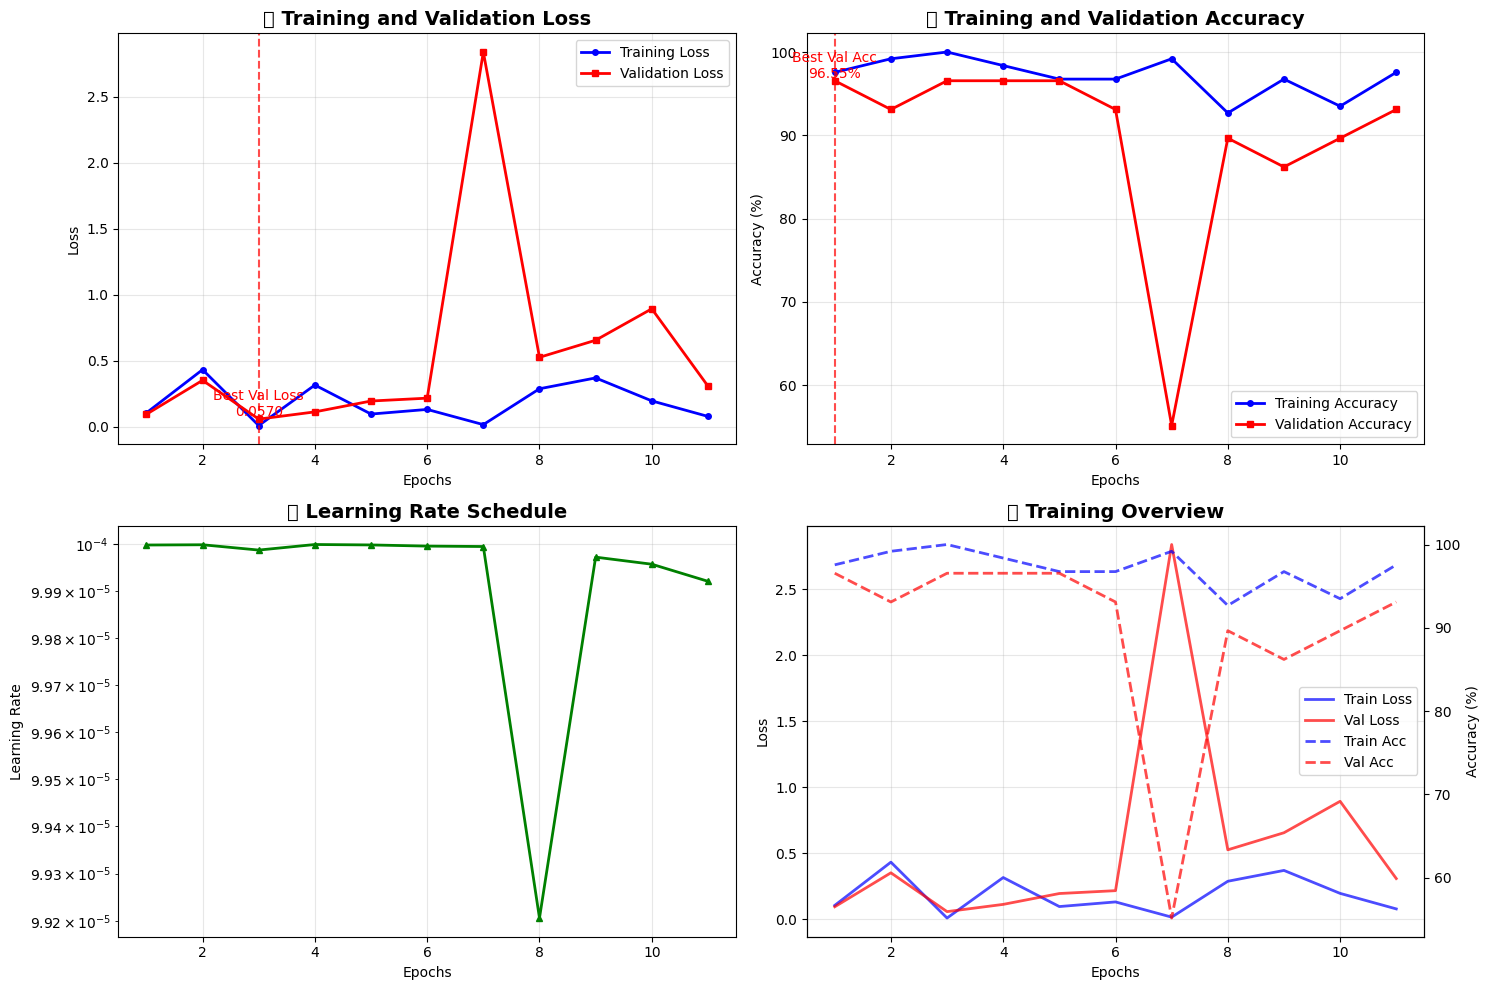


📊 FINAL TRAINING STATISTICS:
   • Final Training Loss: 0.0776
   • Final Validation Loss: 0.3077
   • Final Training Accuracy: 97.56%
   • Final Validation Accuracy: 93.10%
   • Best Validation Accuracy: 96.55%
   • Total Epochs Trained: 11
   • Best Epoch: 1


In [39]:
# Run the training
history = train_and_visualize_complete(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=50,
    model_save_path=model_save_path
)

In [41]:
# =============================================================================
# TEST THE NETWORK ON TESTING DATASET
# =============================================================================

def test_network_on_test_set(model, test_loader, device, classes, model_path=model_save_path):
    """
    Test the trained network on the testing dataset
    """
    print(" TESTING NETWORK ON TEST DATASET")
    print("=" * 60)

    # Load the trained model
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f" Loaded trained model from: {model_path}")
        print(f" Best validation accuracy: {checkpoint.get('val_accuracy', 'N/A')}%")
    except FileNotFoundError:
        print(f"  Model file not found. Using current model weights.")

    model.eval()

    # Test the model
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    print(f"\n Running inference on test set ({len(test_loader.dataset)} samples)...")

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Handle both batch formats
            if len(batch) == 3:
                images, labels, _ = batch
            else:
                images, labels = batch

            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            # Update counters
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store results
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Calculate accuracy
    test_accuracy = 100 * correct / total

    print(f"\n TEST RESULTS:")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Correct Predictions: {correct}/{total}")
    print(f"Test Samples: {total}")

    return all_predictions, all_labels, all_probabilities, test_accuracy

def print_detailed_results(true_labels, predictions, probabilities, classes):
    """
    Print detailed classification results
    """
    from sklearn.metrics import classification_report, confusion_matrix

    print(f"\n DETAILED RESULTS")
    print("=" * 50)

    # Convert to numpy
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Classification report
    print("\n CLASSIFICATION REPORT:")
    print(classification_report(true_labels, predictions, target_names=classes, digits=4))

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print(f"\n CONFUSION MATRIX:")
    print(f"Actual\\Predicted | {classes[0]:^10} | {classes[1]:^10}")
    print("-" * 35)
    for i, class_name in enumerate(classes):
        print(f"{class_name:^15} | {cm[i][0]:^10} | {cm[i][1]:^10}")

    # Class-wise accuracy
    print(f"\n CLASS-WISE ACCURACY:")
    for i, class_name in enumerate(classes):
        class_mask = (true_labels == i)
        class_correct = (predictions[class_mask] == true_labels[class_mask]).sum()
        class_total = class_mask.sum()
        class_accuracy = 100 * class_correct / class_total if class_total > 0 else 0
        print(f"  {class_name}: {class_correct}/{class_total} ({class_accuracy:.2f}%)")

    return cm

def calculate_confidence_stats(predictions, probabilities, true_labels):
    """
    Calculate confidence statistics
    """
    print(f"\n CONFIDENCE STATISTICS")
    print("=" * 50)

    correct_confidences = []
    incorrect_confidences = []

    for i, (pred, true, prob) in enumerate(zip(predictions, true_labels, probabilities)):
        confidence = prob[pred]  # Confidence in predicted class
        if pred == true:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)

    if correct_confidences:
        print(f" Correct predictions: {len(correct_confidences)}")
        print(f"   Average confidence: {np.mean(correct_confidences):.3f}")
        print(f"   Min confidence: {np.min(correct_confidences):.3f}")
        print(f"   Max confidence: {np.max(correct_confidences):.3f}")

    if incorrect_confidences:
        print(f" Incorrect predictions: {len(incorrect_confidences)}")
        print(f"   Average confidence: {np.mean(incorrect_confidences):.3f}")
        print(f"   Min confidence: {np.min(incorrect_confidences):.3f}")
        print(f"   Max confidence: {np.max(incorrect_confidences):.3f}")

# =============================================================================
# RUN THE TEST
# =============================================================================

print("STARTING NETWORK TEST ON TESTING DATASET")
print("=" * 60)

# Test the network
predictions, true_labels, probabilities, test_accuracy = test_network_on_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    classes=classes
)

# Print detailed results
cm = print_detailed_results(true_labels, predictions, probabilities, classes)

# Calculate confidence statistics
calculate_confidence_stats(predictions, probabilities, true_labels)

print(f"\n TESTING COMPLETED SUCCESSFULLY!")

STARTING NETWORK TEST ON TESTING DATASET
 TESTING NETWORK ON TEST DATASET
 Loaded trained model from: /content/drive/MyDrive/BML815_Alexnet_training /Dental/models/best_alexnet_modified_2.pth
 Best validation accuracy: 96.55172413793103%

 Running inference on test set (38 samples)...


Testing: 100%|██████████| 5/5 [00:00<00:00, 14.26it/s]


 TEST RESULTS:
Test Accuracy: 97.37%
Correct Predictions: 37/38
Test Samples: 38

 DETAILED RESULTS

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0     0.9500    1.0000    0.9744        19
           1     1.0000    0.9474    0.9730        19

    accuracy                         0.9737        38
   macro avg     0.9750    0.9737    0.9737        38
weighted avg     0.9750    0.9737    0.9737        38


 CONFUSION MATRIX:
Actual\Predicted |     0      |     1     
-----------------------------------
       0        |     19     |     0     
       1        |     1      |     18    

 CLASS-WISE ACCURACY:
  0: 19/19 (100.00%)
  1: 18/19 (94.74%)

 CONFIDENCE STATISTICS
 Correct predictions: 37
   Average confidence: 1.000
   Min confidence: 0.997
   Max confidence: 1.000
 Incorrect predictions: 1
   Average confidence: 0.978
   Min confidence: 0.978
   Max confidence: 0.978

 TESTING COMPLETED SUCCESSFULLY!


In [42]:
Img_no= 6
test_image_path= test_paths[Img_no] #  change this path as needed
test_Label = test_labels[Img_no]

✅ Predicted: 0 (Confidence: 1.00)
✅ GT: 0


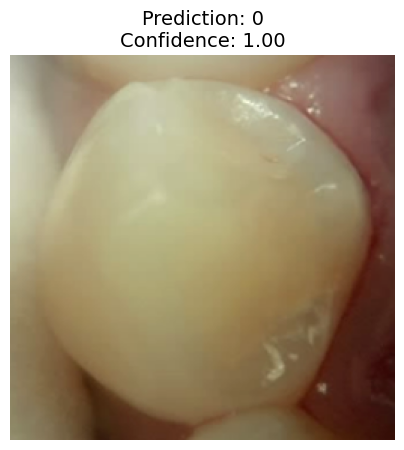

In [43]:
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import os

# =============================================================================
# STEP 1: Define the same transformations used during training
# =============================================================================
input_size = 224  # Must match AlexNet input size (224×224)
test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Open and preprocess
image = Image.open(test_image_path).convert('RGB')
input_tensor = test_transforms(image).unsqueeze(0).to(device)  # add batch dimension

# =============================================================================
# STEP 4: Run inference
# =============================================================================
with torch.no_grad():
    outputs = model(input_tensor)
    probs = F.softmax(outputs, dim=1)
    confidence, pred_class = torch.max(probs, 1)

# =============================================================================
# STEP 5: Get readable results
# =============================================================================
classes = ['0', '1']  #  modify these to your real class names
pred_label = classes[pred_class.item()]
conf_score = confidence.item()

print(f"✅ Predicted: {pred_label} (Confidence: {conf_score:.2f})")
print(f"✅ GT: {test_Label}")

# =============================================================================
# STEP 6: Visualize image and prediction
# =============================================================================
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(f"Prediction: {pred_label}\nConfidence: {conf_score:.2f}", fontsize=14)
plt.axis('off')
plt.show()
